# dev_climapy_xr.ipynb
## Purpose
Development and testing of functions in climapy.climapy_xr.

## Dependencies
- Python packages listed below.
- [Climate Data Operators (CDO)](https://code.zmaw.de/projects/cdo) - required for testing purposes.

## Author
Benjamin S. Grandey, 2017

In [1]:
import climapy
import copy
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import os
import xarray as xr

%matplotlib inline

In [2]:
help(climapy)

Help on package climapy:

NAME
    climapy

DESCRIPTION
    climapy:
    Support data analysis of climate model data.
    
    Author:
    Benjamin S. Grandey, 2017

PACKAGE CONTENTS
    climapy_xr

FILE
    /Users/grandey/github/climapy/climapy/__init__.py




## Input data location
For development and testing, I will use NetCDF data files from [*Data for "Radiative effects of interannually varying vs. interannually invariant aerosol emissions from fires"* (doi: 10.6084/m9.figshare.3497705.v5)](https://doi.org/10.6084/m9.figshare.3497705.v5).

In [3]:
# Location of gunzipped input NetCDF files - CHANGE IF NECESSARY
data_dir = '$HOME/data/figshare/figshare3497705v5/'
data_dir = os.path.expandvars(data_dir)
data_dir

'/Users/grandey/data/figshare/figshare3497705v5/'

## Temporary data location

In [4]:
# Directory where temporary data files can be written - CHANGE IF NECESSARY
temp_dir = '$HOME/data/temp/'
temp_dir = os.path.expandvars(temp_dir)
temp_dir

'/Users/grandey/data/temp/'

In [5]:
# Start (prefix) of name of temporary data files
temp_pre = 'temp_dev_climapy_xr_'
temp_pre

'temp_dev_climapy_xr_'

## Clean up previously created temporary files?
If previously created temporary files are found, user input is required. The recommended answer is 'y'. But proceed with cautioun - this cannot be undone.

In [6]:
# Clean up temporary data files previously created? Recommended, but be cautious.
temp_file_list = glob(temp_dir+temp_pre+'*')
if temp_file_list:
    s = input('Temporary files found: {}\n'.format(temp_file_list) +
              '*Would you like to permanently delete these files?* Type "y" if so.\n' +
              'Your response: ')
    if s == 'y':
        for temp_file in temp_file_list:
            print('Deleting {}'.format(temp_file))
            os.remove(temp_file)
    else:
        print('Files not deleted.')
else:
    print('No temporary files found.')

No temporary files found.


## Prepare Datasets

In [7]:
# Dictionaries in which to store Datasets
f0_dict = {}  # Datasets derived from "F0" simulation data
fmean_dict = {}  # Datasets derived from "FMEAN" simulation data

# Load data for simulations F0 and FMEAN
f0 = xr.open_dataset(data_dir+'bb0_o2000.nc', decode_times=False)  # F0
fmean = xr.open_dataset(data_dir+'bb9706_o2000.nc', decode_times=False)  # FMEAN
f0_dict['input'] = f0.copy()  # store in dict
fmean_dict['input'] = fmean.copy()

# Datasets with shifted longitudes - using xr_shift_lon
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds = climapy.xr_shift_lon(ds)
    f['shift_lon'] = ds.copy()

# Datasets with *renamed* lon and lat dimensions
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds = ds.rename({'lon': 'longitude', 'lat': 'latitude'})
    f['renamed'] = ds.copy()
    
# Datasets with *reversed* lon and lat coords
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds['lon'].values = ds['lon'].values[::-1]
    ds['lat'].values = ds['lat'].values[::-1]
    for variable in ds.variables:
        if variable not in ds.coords and variable != 'time_bnds':
            ds[variable].values = ds[variable].values[:, ::-1, ::-1]
    f['reversed'] = ds.copy()  # both reversed
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds['lon'].values = ds['lon'].values[::-1]
    for variable in ds.variables:
        if variable not in ds.coords and variable != 'time_bnds':
            ds[variable].values = ds[variable].values[:, :, ::-1]
    f['reversed_lon'] = ds.copy()
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds['lat'].values = ds['lat'].values[::-1]
    for variable in ds.variables:
        if variable not in ds.coords and variable != 'time_bnds':
            ds[variable].values = ds[variable].values[:, ::-1, :]
    f['reversed_lat'] = ds.copy()
    
# Datasets with *transposed* lon and lat dimensions
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds = ds.transpose()
    f['transposed'] = ds.copy()
    
# Datasets with slightly *irregular* lon/lat coords, yet still monotonic
ds = f0_dict['input'].copy()
nx, ny = ds['lon'].size, ds['lat'].size
lon_irr = ds['lon'].values + np.random.uniform(low=-0.01, high=0.01, size=nx)  # add small amount of noise
lat_irr = ds['lat'].values + np.random.uniform(low=-0.01, high=0.01, size=ny)
lat_irr[0] = -89.99  # min latitude should be > -90
lat_irr[-1] = 89.99  # max latitude should be < -90
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds['lon'].values = lon_irr
    ds['lat'].values = lat_irr
    f['irregular'] = ds.copy()

# Datasets with *strange* lon/lat coords - very irregular and out of order
ds = f0_dict['input'].copy()
nx, ny = ds['lon'].size, ds['lat'].size
lon_strange = ds['lon'].values + np.random.uniform(low=-10, high=10, size=nx)  # add large amount of noise
lat_strange = ds['lat'].values + np.random.uniform(low=-10, high=10, size=ny)
if np.all(np.diff(lat_strange) > 0):  # check that lat and lon do not increase montonically
    print('!!! Latitude still montonically increasing! RE-RUN CELL. !!!')
if np.all(np.diff(lon_strange) > 0):
    print('!!! Longitude still montonically increasing! RE-RUN CELL. !!!')
for f in [f0_dict, fmean_dict]:
    ds = f['input'].copy()
    ds['lon'].values = lon_strange
    ds['lat'].values = lat_strange
    f['strange'] = ds.copy()

print('f0_dict has keys {}'.format(f0_dict.keys()))
print('fmean_dict has keys {}'.format(fmean_dict.keys()))

f0_dict has keys dict_keys(['input', 'shift_lon', 'renamed', 'reversed', 'reversed_lon', 'reversed_lat', 'transposed', 'irregular', 'strange'])
fmean_dict has keys dict_keys(['input', 'shift_lon', 'renamed', 'reversed', 'reversed_lon', 'reversed_lat', 'transposed', 'irregular', 'strange'])


In [8]:
# Create deep copy of these dictionaries to check that data not modified in place by functions - see end of notebook
f0_dict_dc = copy.deepcopy(f0_dict)
fmean_dict_dc = copy.deepcopy(fmean_dict)

## xr_check_lon_lat_match

In [9]:
help(climapy.xr_check_lon_lat_match)

Help on function xr_check_lon_lat_match in module climapy.climapy_xr:

xr_check_lon_lat_match(xr_data_1, xr_data_2, lon_name='lon', lat_name='lat')
    Check whether longitude and latitude coordinates are equal.
    
    Keyword arguments:
    xr_data_1 -- first xarray Dataset or DataArray, with longitude and latitude dimensions
    xr_data_2 -- second xarray Dataset or DataArray, with longitude and latitude dimensions
    lon_name -- the name of the longitude dimension and coordinate (default 'lon')
    lat_name -- the name of the longitude dimension and coordinate (default 'lon')
    
    Returns:
    True or False



In [10]:
# Test 1: use every F0,FMEAN pair of Datasets
# Expected result: should all be True
for key in f0_dict.keys():
    if key == 'renamed':
        result = climapy.xr_check_lon_lat_match(f0_dict[key], fmean_dict[key],
                                                lon_name='longitude', lat_name='latitude')
    else:
        result = climapy.xr_check_lon_lat_match(f0_dict[key], fmean_dict[key])
    print('{} for "{}"'.format(result, key))

True for "input"
True for "shift_lon"
True for "renamed"
True for "reversed"
True for "reversed_lon"
True for "reversed_lat"
True for "transposed"
True for "irregular"
True for "strange"


In [11]:
# Test 2: use every F0,FMEAN pair of temperature DataArrays
# Expected result: should all be True
for key in f0_dict.keys():
    if key == 'renamed':
        result = climapy.xr_check_lon_lat_match(f0_dict[key]['TS'], fmean_dict[key]['TS'],
                                                lon_name='longitude', lat_name='latitude')
    else:
        result = climapy.xr_check_lon_lat_match(f0_dict[key]['TS'], fmean_dict[key]['TS'])
    print('{} for "{}"'.format(result, key))

True for "input"
True for "shift_lon"
True for "renamed"
True for "reversed"
True for "reversed_lon"
True for "reversed_lat"
True for "transposed"
True for "irregular"
True for "strange"


In [12]:
# Test 3: compare F0['input'] with every other F0 Dataset (apart from 'renamed', due to diff dim names)
# Expected result: should all be False, apart from transposed which should be True
for key in f0_dict.keys():
    if key not in ['input', 'renamed']:
        result = climapy.xr_check_lon_lat_match(f0_dict['input'], f0_dict[key])
        print('{} for "{}"'.format(result, key))

False for "shift_lon"
False for "reversed"
False for "reversed_lon"
False for "reversed_lat"
True for "transposed"
False for "irregular"
False for "strange"


In [13]:
# Test 4: compare F0['input']['TS'] with every other F0 'TS' DataArray (apart from 'renamed', due to diff dim names)
# Expected result: should all be False, apart from transposed which should be True
for key in f0_dict.keys():
    if key not in ['input', 'renamed']:
        result = climapy.xr_check_lon_lat_match(f0_dict['input']['TS'], f0_dict[key]['TS'])
        print('{} for "{}"'.format(result, key))

False for "shift_lon"
False for "reversed"
False for "reversed_lon"
False for "reversed_lat"
True for "transposed"
False for "irregular"
False for "strange"


## xr_shift_lon

In [14]:
help(climapy.xr_shift_lon)

Help on function xr_shift_lon in module climapy.climapy_xr:

xr_shift_lon(xr_data, lon_min=-180.0, lon_name='lon')
    Shift longitudes of an xarray Dataset or DataArray.
    
    Keyword arguments:
    xr_data -- an xarray Dataset or DataArray, with a longitude dimension
    lon_min -- the minimum longitude requested (default -180.)
    lon_name -- the name of the longitude dimension (default 'lon')
    
    Returns:
    Copy of input object, with longitudes shifted to the range lon_min to lon_min+360.



ds1 longitudes range from 0.0 to 357.5
ds2 longitudes range from -180.0 to 177.5


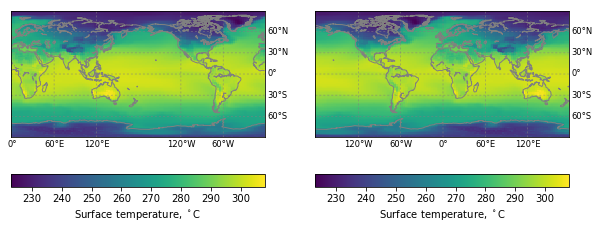

In [15]:
# Example: display result of applying xr_shift_lon to a Dataset
ds1 = f0_dict['input']
print('ds1 longitudes range from {} to {}'.format(*ds1['lon'].values[[0, -1]]))
ds2 = climapy.xr_shift_lon(ds1)
print('ds2 longitudes range from {} to {}'.format(*ds2['lon'].values[[0, -1]]))
# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
for ax, ds, title in zip(axs, [ds1, ds2], ['ds1 (unshifted)', 'ds2 (longitudes shifted)']):
    # Longitude and latitude values
    lon, lat = ds['lon'].values, ds['lat'].values
    lon0 = lon[0] - ((lon[1] - lon[0]) / 2.0)  # lower bound for first longitude bin
    lat0 = lat[0] - ((lat[1] - lat[0]) / 2.0)  # pseudo lower bound for first latitude bin
    # Set up map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(color='0.5')
    bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                      color='0.5', linewidth=0.5)
    bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                      color='0.5', linewidth=0.5)
    # Plot data and colour bar
    data = ds.isel(time=0)['TS'] - 273.15  # surface temperature in degC
    im = ax.imshow(ds.isel(time=0)['TS'].values, extent=[lon0, 360+lon0, -lat0, lat0])
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal')
    cbar.set_label('Surface temperature, $^\circ$C')

In [16]:
# Test 1: for Datasets, shift longitudes to a specified range then shift back
for key in f0_dict.keys():
    print('key = {}'.format(key))
    if key == 'renamed':
        lon_name = 'longitude'
    else:
        lon_name = 'lon'
    for lon_min in [-180., -270., 0.]:  # try diff ranges
        print('  lon_min = {}'.format(lon_min))
        try:
            # Shift longitudes
            ds = climapy.xr_shift_lon(f0_dict[key], lon_min=lon_min, lon_name=lon_name)
            # Print information about original and new longitude values
            start_end_orig = tuple(f0_dict[key][lon_name].values[[0, -1]])  # original start and end lon values
            min_max_orig = tuple(np.sort(f0_dict[key][lon_name].values)[[0, -1]])  # original min and max lon values
            start_end_new = tuple(ds[lon_name].values[[0, -1]])  # new start and end lon values
            min_max_new = tuple(np.sort(ds[lon_name].values)[[0, -1]])  # new min and max lon values
            print('    [start, end]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]; '
                  '[min, max]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]'.format(*start_end_orig, *start_end_new,
                                                                            *min_max_orig, *min_max_new))
            # Shift longitudes back and check whether equal to original
            print('    Equal to original before shifting back? {}'.format(ds.equals(f0_dict[key])))
            ds = climapy.xr_shift_lon(ds, lon_min=min_max_orig[0], lon_name=lon_name)
            print('    Equal to original after shifting back? {}'.format(ds.equals(f0_dict[key])))
            if not ds.equals(f0_dict[key]):
                print('    Largest difference in lon values is '
                      '{}'.format(np.max(np.abs(ds['lon'].values - f0_dict[key]['lon'].values))))
                ds = ds.reindex_like(f0_dict[key], method='nearest', tolerance=1e-3)
                print('    Equal to original after re-indexing with tolerance? '
                      '{}'.format(ds.equals(f0_dict[key])))
                if not ds.equals(f0_dict[key]):
                    print('    PROBLEM: not equal to original after re-indexing with tolerance')
        except ValueError:
            if key == 'strange':
                print('    Encountered ValueError, as expected for "strange".')
            else:
                print('    PROBLEM: encountered unexpected ValueError')

key = input
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = 0.0
    [start, end]: [0.0, 357.5] -> [0.0, 357.5]; [min, max]: [0.0, 357.5] -> [0.0, 357.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
key = shift_lon
  lon_min = -180.0
    [start, end]: [-180.0, 177.5] -> [-180.0, 177.5]; [min, max]: [-180.0, 177.5] -> [-180.0, 177.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [-180.0, 177.5] -> [-270.0, 87.5]; [min, max]: [-180.0, 177.5] -> [-270.0, 87.5]
    Equal to 

In [17]:
# Test 2: for DataArrays, shift longitudes to a specified range then shift back
for key in f0_dict.keys():
    print('key = {}'.format(key))
    if key == 'renamed':
        lon_name = 'longitude'
    else:
        lon_name = 'lon'
    for lon_min in [-180., -270., 0.]:  # try diff ranges
        print('  lon_min = {}'.format(lon_min))
        try:
            # Shift longitudes
            da = climapy.xr_shift_lon(f0_dict[key]['TS'], lon_min=lon_min, lon_name=lon_name)
            # Print information about original and new longitude values
            start_end_orig = tuple(f0_dict[key]['TS'][lon_name].values[[0, -1]])  # original start and end lon values
            min_max_orig = tuple(np.sort(f0_dict[key]['TS'][lon_name].values)[[0, -1]])  # original min and max lon values
            start_end_new = tuple(da[lon_name].values[[0, -1]])  # new start and end lon values
            min_max_new = tuple(np.sort(da[lon_name].values)[[0, -1]])  # new min and max lon values
            print('    [start, end]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]; '
                  '[min, max]: [{:.1f}, {:.1f}] -> [{:.1f}, {:.1f}]'.format(*start_end_orig, *start_end_new,
                                                                            *min_max_orig, *min_max_new))
            # Shift longitudes back and check whether equal to original
            print('    Equal to original before shifting back? {}'.format(da.equals(f0_dict[key]['TS'])))
            da = climapy.xr_shift_lon(da, lon_min=min_max_orig[0], lon_name=lon_name)
            print('    Equal to original after shifting back? {}'.format(da.equals(f0_dict[key]['TS'])))
            if not da.equals(f0_dict[key]['TS']):
                print('    Largest difference in lon values is '
                      '{}'.format(np.max(np.abs(da['lon'].values - f0_dict[key]['TS']['lon'].values))))
                da = da.reindex_like(f0_dict[key]['TS'], method='nearest', tolerance=1e-3)
                print('    Equal to original after re-indexing with tolerance? '
                      '{}'.format(da.equals(f0_dict[key]['TS'])))
                if not da.equals(f0_dict[key]['TS']):
                    print('    PROBLEM: not equal to original after re-indexing with tolerance')
        except ValueError:
            if key == 'strange':
                print('    Encountered ValueError, as expected for "strange".')
            else:
                print('    PROBLEM: encountered unexpected ValueError')

key = input
  lon_min = -180.0
    [start, end]: [0.0, 357.5] -> [-180.0, 177.5]; [min, max]: [0.0, 357.5] -> [-180.0, 177.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [0.0, 357.5] -> [-270.0, 87.5]; [min, max]: [0.0, 357.5] -> [-270.0, 87.5]
    Equal to original before shifting back? False
    Equal to original after shifting back? True
  lon_min = 0.0
    [start, end]: [0.0, 357.5] -> [0.0, 357.5]; [min, max]: [0.0, 357.5] -> [0.0, 357.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
key = shift_lon
  lon_min = -180.0
    [start, end]: [-180.0, 177.5] -> [-180.0, 177.5]; [min, max]: [-180.0, 177.5] -> [-180.0, 177.5]
    Equal to original before shifting back? True
    Equal to original after shifting back? True
  lon_min = -270.0
    [start, end]: [-180.0, 177.5] -> [-270.0, 87.5]; [min, max]: [-180.0, 177.5] -> [-270.0, 87.5]
    Equal to 

## xr_area

In [18]:
help(climapy.xr_area)

Help on function xr_area in module climapy.climapy_xr:

xr_area(xr_data, lon_name='lon', lat_name='lat')
    Calculate grid-cell areas of an xarray Dataset or DataArray.
    
    Keyword arguments:
    xr_data -- an xarray Dataset or DataArray, with lon and lat dimensions
    lon_name -- the name of the longitude dimension and coordinate (default 'lon')
    lat_name -- the name of the longitude dimension and coordinate (default 'lon')
    
    Returns:
    xarray DataArray named 'area', containing grid-cell areas.



In [19]:
# Use CDO to create reference data for testing purposes
in_filename = data_dir + 'bb0_o2000.nc'
out_filename = temp_dir + temp_pre + 'area.nc'
!cdo gridarea {in_filename} {out_filename}
# Load reference data
cdo_area = xr.open_dataset(out_filename)['cell_area']  # load as DataArray
cdo_area

cdo gridarea:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                  cdo gridarea: Processed 21 variables ( 0.01s )


<xarray.DataArray 'cell_area' (lat: 96, lon: 144)>
array([[  2.420179e+08,   2.420179e+08,   2.420179e+08, ...,   2.420179e+08,
          2.420179e+08,   2.420179e+08],
       [  1.935747e+09,   1.935747e+09,   1.935747e+09, ...,   1.935747e+09,
          1.935747e+09,   1.935747e+09],
       [  3.869384e+09,   3.869384e+09,   3.869384e+09, ...,   3.869384e+09,
          3.869384e+09,   3.869384e+09],
       ..., 
       [  3.869384e+09,   3.869384e+09,   3.869384e+09, ...,   3.869384e+09,
          3.869384e+09,   3.869384e+09],
       [  1.935747e+09,   1.935747e+09,   1.935747e+09, ...,   1.935747e+09,
          1.935747e+09,   1.935747e+09],
       [  2.420179e+08,   2.420179e+08,   2.420179e+08, ...,   2.420179e+08,
          2.420179e+08,   2.420179e+08]])
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 -78.63 ...
Attributes:
    standard_name: area
    long_name: area of

In [20]:
# Test 1: Compare area calculated by xr_area with reference area calculated by CDO
area = climapy.xr_area(f0_dict['input'])
# Check if lon/lat coordinates identical
print('Comparing to cdo gridarea result...')
if climapy.xr_check_lon_lat_match(area, cdo_area):
    print('Longitudes and latitudes equal.')
else:
    print('PROBLEM: longitudes and latitudes not equal.')
# Check percentage difference
perc = (area - cdo_area) / cdo_area * 100  # % difference
print('% differences range from {:.3f}% to {:.3f}%.'.format(perc.values.min(), perc.values.max()))
if np.abs(perc).max() > 0.1:
    print('PROBLEM: largest % difference > +/-0.1%.')
# Check sum (ie global total)
print('Sum of cdo     result is {:.0f}m2.'.format(cdo_area.values.sum()))
print('Sum of xr_area result is {:.0f}m2.'.format(area.values.sum()))
print('The difference is {:.0f}m2.'.format(area.values.sum() - cdo_area.values.sum()))
if (np.abs(area.values.sum() - cdo_area.values.sum()) / cdo_area.values.sum()) * 100 > 1e-4:
    print('PROBLEM: relative difference > +/-0.0001%.')

Comparing to cdo gridarea result...
Longitudes and latitudes equal.
% differences range from -0.016% to 0.032%.
Sum of cdo     result is 510064471909788m2.
Sum of xr_area result is 510064471909788m2.
The difference is 0m2.


In [21]:
# Test 2: For Datasets, compare % differences and global totals
print('Comparing to cdo gridarea result...')
for key in f0_dict.keys():
    try:
        print('key = {}'.format(key))
        if key == 'renamed':
            lon_name, lat_name = 'longitude', 'latitude'
        else:
            lon_name, lat_name = 'lon', 'lat'
        # Calculate area
        area = climapy.xr_area(f0_dict[key], lon_name=lon_name, lat_name=lat_name)
        # Compare lon-lat coords
        if key != 'renamed':
            if climapy.xr_check_lon_lat_match(area, cdo_area):
                print('  Longitudes and latitudes equal.')
            else:
                print('  Longitudes and latitudes not equal.')
        else:
            print('  Skipping coord comparision for "renamed".')
        # Look at % differences
        perc = (area.values - cdo_area.values) / cdo_area.values * 100  # use np arrays since coords may not match
        print('  % differences range from {:.3f}% to {:.3f}%.'.format(perc.min(), perc.max()))
        if np.abs(perc).max() > 0.1 and key not in ['irregular', 'strange']:
            print('  PROBLEM: largest % difference > +/-0.1%.')
        # Check sum
        print('  Sum of xr_area result is {:.0f}m2.'.format(area.values.sum()))
        print('  The difference is {:.0f}m2.'.format(area.values.sum() - cdo_area.values.sum()))
        if (np.abs(area.values.sum() - cdo_area.values.sum()) / cdo_area.values.sum()) * 100 > 1e-2:
            print('  PROBLEM: relative difference > +/-0.01%.')
    except ValueError:
        if key == 'strange':
            print('  ValueError encountered, as expected for "strange".')
        else:
            print('  PROBLEM: unexpected ValueError encountered.')

Comparing to cdo gridarea result...
key = input
  Longitudes and latitudes equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = shift_lon
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = renamed
  Skipping coord comparision for "renamed".
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed_lon
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed_lat
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of

/Users/grandey/github/climapy/climapy/climapy_xr.py:152: UserWarning: Total area calculated differs from spherical Earth by 0.006312077246299412%
  'spherical Earth by {}%'.format(perc_diff))


In [22]:
# Test 3: For DataArrays, compare % differences and global totals
print('Comparing to cdo gridarea result...')
for key in f0_dict.keys():
    try:
        print('key = {}'.format(key))
        if key == 'renamed':
            lon_name, lat_name = 'longitude', 'latitude'
        else:
            lon_name, lat_name = 'lon', 'lat'
        # Calculate area
        area = climapy.xr_area(f0_dict[key]['TS'], lon_name=lon_name, lat_name=lat_name)
        # Compare lon-lat coords
        if key != 'renamed':
            if climapy.xr_check_lon_lat_match(area, cdo_area):
                print('  Longitudes and latitudes equal.')
            else:
                print('  Longitudes and latitudes not equal.')
        else:
            print('  Skipping coord comparision for "renamed".')
        # Look at % differences
        perc = (area.values - cdo_area.values) / cdo_area.values * 100  # use np arrays since coords may not match
        print('  % differences range from {:.3f}% to {:.3f}%.'.format(perc.min(), perc.max()))
        if np.abs(perc).max() > 0.1 and key not in ['irregular', 'strange']:
            print('  PROBLEM: largest % difference > +/-0.1%.')
        # Check sum
        print('  Sum of xr_area result is {:.0f}m2.'.format(area.values.sum()))
        print('  The difference is {:.0f}m2.'.format(area.values.sum() - cdo_area.values.sum()))
        if (np.abs(area.values.sum() - cdo_area.values.sum()) / cdo_area.values.sum()) * 100 > 1e-2:
            print('  PROBLEM: relative difference > +/-0.01%.')
    except ValueError:
        if key == 'strange':
            print('  ValueError encountered, as expected for "strange".')
        else:
            print('  PROBLEM: unexpected ValueError encountered.')

Comparing to cdo gridarea result...
key = input
  Longitudes and latitudes equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = shift_lon
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = renamed
  Skipping coord comparision for "renamed".
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed_lon
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of xr_area result is 510064471909788m2.
  The difference is 0m2.
key = reversed_lat
  Longitudes and latitudes not equal.
  % differences range from -0.016% to 0.032%.
  Sum of

/Users/grandey/github/climapy/climapy/climapy_xr.py:152: UserWarning: Total area calculated differs from spherical Earth by 0.006312077246299412%
  'spherical Earth by {}%'.format(perc_diff))


## xr_mask_bounds

In [23]:
help(climapy.xr_mask_bounds)

Help on function xr_mask_bounds in module climapy.climapy_xr:

xr_mask_bounds(xr_data, lon_bounds=(-180, 180), lat_bounds=(-90, 90), select_how='inside', lon_name='lon', lat_name='lat')
    Select inside/outside specified region bounds, and mask elsewhere.
    
    Keyword arguments:
    xr_data -- an xarray Dataset or DataArray, with longitude and latitude dimensions
    lon_bounds -- tuple/list containing longitude bounds (default (-180, 180))
    lat_bounds -- tuple/list containing latitude bounds (default (-90, 90))
    select_how -- select data either 'inside' region (ie mask outside; default) or 'outside' region
    lon_name -- the name of the longitude dimension and coordinate (default 'lon')
    lat_name -- the name of the longitude dimension and coordinate (default 'lon')
    
    Returns:
    Copy of input object, with masking applied.



In [24]:
# Region bounds dictionary for development/testing purposes
region_bounds_dict = {'EAs': [(94, 156), (20, 65)],  # longitude tuple, latitude tuple
                      'SEAs': [(94, 161), (-10, 20)],
                      'ANZ': [(109, 179), (-50, -10)],
                      'SAs': [(61, 94), (0, 35)],
                      'AfME': [(-21, 61), (-40, 35)],
                      'Eur': [(-26, 31), (35, 75)],
                      'CAs': [(31, 94), (35, 75)],
                      'NAm': [(-169, -51), (15, 75)],
                      'SAm': [(266, 329), (-60, 15)],
                      'Zon': [None, (-75.5, -65.5)],
                      'Mer': [(175.5, 185.5), None],
                      'Glb': [None, None]}
region_bounds_dict.keys()

dict_keys(['EAs', 'SEAs', 'ANZ', 'SAs', 'AfME', 'Eur', 'CAs', 'NAm', 'SAm', 'Zon', 'Mer', 'Glb'])

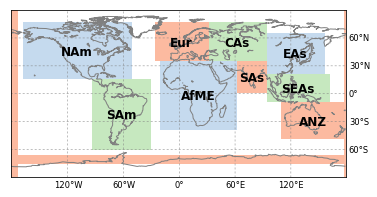

In [25]:
# Example: map for select_how='inside'
ds = f0_dict['shift_lon']
lon, lat = ds['lon'].values, ds['lat'].values
lon0 = lon[0] - ((lon[1] - lon[0]) / 2.0)  # lower bound for first longitude bin
lat0 = lat[0] - ((lat[1] - lat[0]) / 2.0)  # pseudo lower bound for first latitude bin
# Set-up map
fig = plt.figure(figsize=(6, 4.5))
bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0)
bm.drawcoastlines(color='0.5')
bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                  color='0.5', linewidth=0.5)
bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                  color='0.5', linewidth=0.5)
# Plot region masks and names
for region, bounds in region_bounds_dict.items():
    lon_bounds, lat_bounds = bounds
    # Set colour map
    if region in ['NAm', 'AfME', 'EAs']:  # shading colour dependent on region
        cmap = 'Blues'
    elif region in ['SAm', 'CAs', 'SEAs']:
        cmap = 'Greens'
    else:
        cmap = 'Reds'
    # Create data for region
    data = ds.isel(time=0)['TS'].copy()
    data[:] = 1
    data = climapy.xr_mask_bounds(data, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
                                  select_how='inside')
    # Plot data and annotation
    if region != 'Glb':
        im = plt.imshow(data, extent=[lon0, lon0+360, -lat0, lat0],
                        interpolation='Nearest', cmap=cmap,
                        vmin=0, vmax=4)
        if lon_bounds and lat_bounds:
            label_pos = [(lon_bounds[0]+lon_bounds[1])/2,
                         (lat_bounds[0]+lat_bounds[1])/2]
            if label_pos[0] > 180:
                label_pos[0] -= 360
            plt.text(label_pos[0], label_pos[1], region,
                     color='k', weight='bold', fontsize='large',
                     horizontalalignment='center', verticalalignment='center')

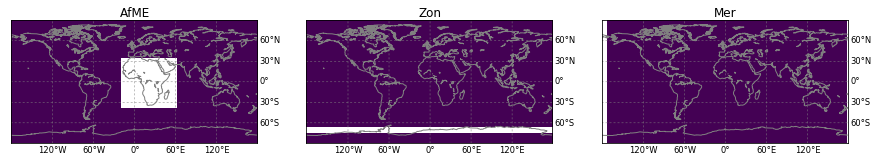

In [26]:
# Example: maps for select_how='outside'
ds = f0_dict['shift_lon']
lon, lat = ds['lon'].values, ds['lat'].values
lon0 = lon[0] - ((lon[1] - lon[0]) / 2.0)  # lower bound for first longitude bin
lat0 = lat[0] - ((lat[1] - lat[0]) / 2.0)  # pseudo lower bound for first latitude bin
# Loop over subfigures
fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, region in zip(axs, ['AfME', 'Zon', 'Mer']):
    # Set up map
    bm = Basemap(llcrnrlat=-90.0, urcrnrlat=90.0, llcrnrlon=lon0, urcrnrlon=360.0+lon0, ax=ax)
    bm.drawcoastlines(color='0.5')
    bm.drawparallels([-60, -30, 0, 30, 60], labels=[0, 1, 0, 0], fontsize='small',
                      color='0.5', linewidth=0.5)
    bm.drawmeridians([-120, -60, 0, 60, 120], labels=[0, 0, 0, 1], fontsize='small',
                      color='0.5', linewidth=0.5)
    # Create data for region
    lon_bounds, lat_bounds = region_bounds_dict[region]
    data = ds.isel(time=0)['TS'].copy()
    data[:] = 1
    data = climapy.xr_mask_bounds(data, lon_bounds=lon_bounds, lat_bounds=lat_bounds,
                                  select_how='outside')
    # Plot data
    im = ax.imshow(data, extent=[lon0, 360+lon0, -lat0, lat0],
                   interpolation='Nearest')
    ax.text(0, 100, region, fontsize='large', horizontalalignment='center', verticalalignment='center')

In [27]:
# Use CDO to create reference data for testing purposes
cdo_dict = {}  # dictionary in which to store reference data
in_filename = data_dir + 'bb0_o2000.nc'
for region, bounds in region_bounds_dict.items():
    out_filename = temp_dir + temp_pre + region + '.nc'
    lon_bounds, lat_bounds = bounds
    if lon_bounds == None:
        lon_bounds = (-180, 180)
    if lat_bounds == None:
        lat_bounds = (-90, 90)
    bounds_str = ','.join([str(x) for x in lon_bounds+lat_bounds])
    !cdo sellonlatbox,{bounds_str} {in_filename} {out_filename} &> /dev/null
    # Load reference data
    cdo_dict[region] = xr.open_dataset(out_filename, decode_times=False)

In [28]:
# Test 1: Compare data masked by xr_mask_bounds with reference data masked by CDO
print('Comparing to cdo sellonlatbox result...')
for region, bounds in region_bounds_dict.items():
    print(region)
    lon_bounds, lat_bounds = bounds
    data = climapy.xr_mask_bounds(f0_dict['input']['TS'], lon_bounds=lon_bounds, lat_bounds=lat_bounds,
                                  select_how='inside')
    data = data.dropna(dim='lon', how='all').dropna(dim='lat', how='all')  # select just region using dropna
    # Compare longitude and latitude
    if climapy.xr_check_lon_lat_match(data, cdo_dict[region]['TS']):
        print('  lon / lat coords equal.')
    else:
        print('  lon / lat coords not equal. Applying xr_shift_lon.')
        data = climapy.xr_shift_lon(data, lon_min=-180.)
        if climapy.xr_check_lon_lat_match(data, cdo_dict[region]['TS']):
            print('  Coords now equal.')
        else:
            print('  PROBLEM: coords still not equal.')
            print('  [start, end] lon values are '
                  '[{}, {}] and [{}, {}]'.format(*data['lon'].values[[0, -1]],
                                                 *cdo_dict[region]['TS']['lon'].values[[0, -1]]))
    if data.equals(cdo_dict[region]['TS']):
        print('  xr_region_bounds result equals cdo result.')
    else:
        print('  PROBLEM: xr_region_bounds result does not equal cdo result.')

Comparing to cdo sellonlatbox result...
EAs
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
SEAs
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
ANZ
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
SAs
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
AfME
  lon / lat coords not equal. Applying xr_shift_lon.
  Coords now equal.
  xr_region_bounds result equals cdo result.
Eur
  lon / lat coords not equal. Applying xr_shift_lon.
  Coords now equal.
  xr_region_bounds result equals cdo result.
CAs
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
NAm
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
SAm
  lon / lat coords equal.
  xr_region_bounds result equals cdo result.
Zon
  lon / lat coords not equal. Applying xr_shift_lon.
  Coords now equal.
  xr_region_bounds result equals cdo result.
Mer
  lon / lat coords equal.
  xr_region_bounds result equals cdo 

## Check that Datasets have not been modified in place

In [29]:
# Check that Datasets in f0_dict are unchanged
# Expected result: True for all
for key in f0_dict.keys():
    print('{} for {}'.format(f0_dict[key].identical(f0_dict_dc[key]), key))

True for input
False for shift_lon
True for renamed
True for reversed
True for reversed_lon
True for reversed_lat
True for transposed
True for irregular
True for strange


In [30]:
# Check that Datasets in fmean_dict are unchanged
# Expected result: True for all
for key in fmean_dict.keys():
    print('{} for {}'.format(fmean_dict[key].identical(fmean_dict_dc[key]), key))

True for input
True for shift_lon
True for renamed
True for reversed
True for reversed_lon
True for reversed_lat
True for transposed
True for irregular
True for strange


## Clean up temporary files?
User input is required. The recommended answer is 'y'. But proceed with cautioun - this cannot be undone.

In [31]:
# Clean up temporary data files? Recommended, but be cautious.
temp_file_list = glob(temp_dir+temp_pre+'*')
if temp_file_list:
    s = input('Temporary files found: {}\n'.format(temp_file_list) +
              '*Would you like to permanently delete these files?* Type "y" if so.\n' +
              'Your response: ')
    if s == 'y':
        for temp_file in temp_file_list:
            print('Deleting {}'.format(temp_file))
            os.remove(temp_file)
    else:
        print('Files not deleted.')
else:
    print('No temporary files found.')

Temporary files found: ['/Users/grandey/data/temp/temp_dev_climapy_xr_AfME.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_ANZ.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_area.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_CAs.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_EAs.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_Eur.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_Glb.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_Mer.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_NAm.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_SAm.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_SAs.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_SEAs.nc', '/Users/grandey/data/temp/temp_dev_climapy_xr_Zon.nc']
*Would you like to permanently delete these files?* Type "y" if so.
Your response: y
Deleting /Users/grandey/data/temp/temp_dev_climapy_xr_AfME.nc
Deleting /Users/grandey/data/temp/temp_dev_climapy_xr_ANZ.nc
Deleting /Users/grandey/data/temp/temp_dev_climapy